In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [2]:
nice_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/nice15_MSS_v2.nc"
nice_ds = xr.open_dataset(nice_nc)

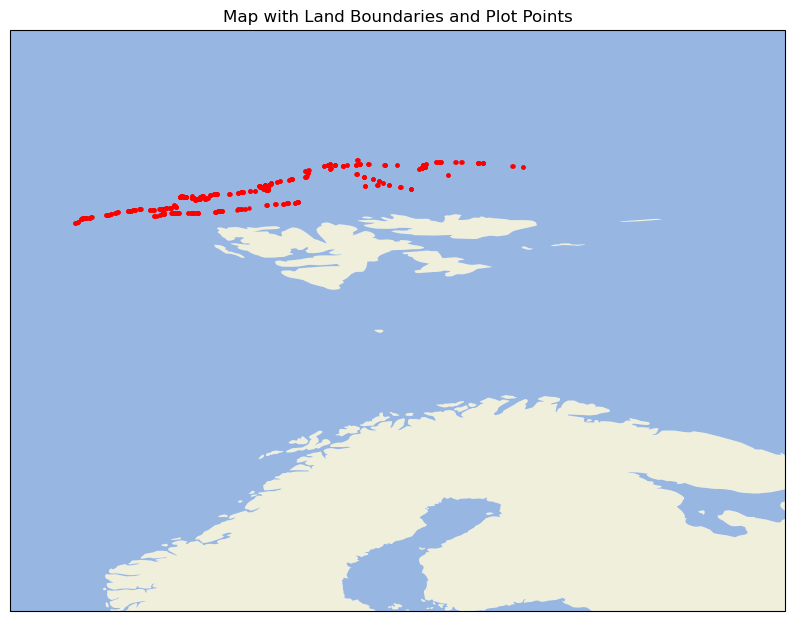

In [3]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(nice_ds.LONGITUDE, nice_ds.LATITUDE, transform=ccrs.PlateCarree(), color='red', s=5)
# ax.scatter(HM_VMP.LONGITUDE, HM_VMP.LATITUDE, transform=ccrs.PlateCarree(), color='', s=5)

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_extent([0, 40, 60, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
plt.show()

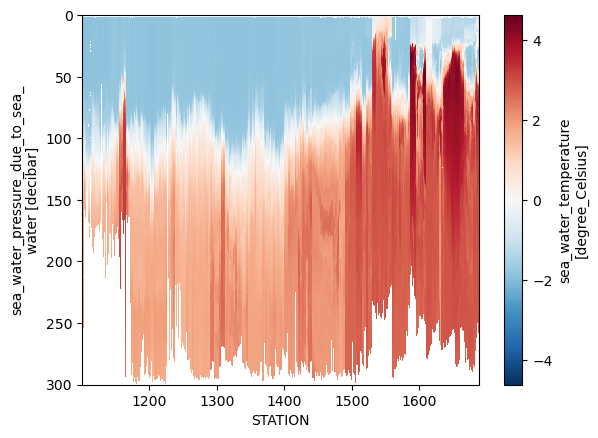

In [4]:
nice_ds.TEMP.plot(y='PRES', x='STATION')
plt.gca().invert_yaxis()

## Bin data to 1m

In [4]:
nice_ds["P"] = nice_ds["PRES"]
nice_ds = nice_ds.rename({'PRES':'depth'})
bin_ds = nice_ds
# group data by depth bins
# adjust the labels to reflect the start of each interval
bin_size = np.arange(0, 300.1, 1)
bin_labels = [edge for edge in bin_size[:-1]]
grouped = bin_ds.groupby_bins('depth', bin_size, labels=bin_labels)
# calculate mean of each bin
binned_data = grouped.mean(dim='depth')
binned_data = binned_data.rename({'depth_bins': 'depth'})
binned_data

<xarray.Dataset>
Dimensions:    (STATION: 588, TIME: 588, LATITUDE: 588, LONGITUDE: 588,
                depth: 300)
Coordinates:
  * STATION    (STATION) float32 1.101e+03 1.102e+03 ... 1.687e+03 1.688e+03
  * TIME       (TIME) datetime64[ns] 2015-01-25T12:28:05.000003584 ... 2015-0...
  * LATITUDE   (LATITUDE) float64 83.0 83.0 83.03 83.03 ... 80.37 80.37 80.37
  * LONGITUDE  (LONGITUDE) float64 19.97 19.96 19.35 19.34 ... 7.465 7.451 7.437
  * depth      (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 296.0 297.0 298.0 299.0
Data variables:
    TEMP       (depth, STATION) float64 nan nan nan nan nan ... nan nan nan nan
    PSAL       (depth, STATION) float64 nan nan nan nan nan ... nan nan nan nan
    EPS        (depth, STATION) float64 1.77e-06 nan nan nan ... nan nan nan nan
    P          (depth) float64 0.6 1.6 2.6 3.6 4.6 ... 296.6 297.6 298.6 299.6
Attributes: (12/34)
    platform_code:                 Drifting ice_camp near RV Lance
    site_code:                     588.0
    cruise_ID:                     N-ICE2015
    instrument_type:               MSS90L
    instrument:                    
    institution:                   Norwegian Polar Institute
    ...                            ...
    keywords_vocabulary:           EARTH SCIENCE>OCEANS>OCEAN TEMPERATURE>WAT...
    keywords:                      GCMD Science keywords
    iso_topic_category:            Oceans
    license:                       Norwegian Polar Institute 
    history:                       
    comment:                       Ocean microstructure dissipation, temperat...

## Rename variable names to make a good format
Time is already in a good format

In [12]:
formatted_ds = binned_data

formatted_ds = formatted_ds.rename_vars({"TEMP": "T", "PSAL": "S", "EPS": "eps"})
formatted_ds = formatted_ds.rename({"STATION": "profile", "TIME": "time"})

# convert lat and lon to data variables to prepare for dimension dropping
formatted_ds["latitude"] = formatted_ds["LATITUDE"]
formatted_ds["longitude"] = formatted_ds["LONGITUDE"]

# Project longitude and latitude onto the profile dimension
formatted_ds['longitude'] = xr.DataArray(formatted_ds['longitude'].values, dims='profile')
formatted_ds['latitude'] = xr.DataArray(formatted_ds['latitude'].values, dims='profile')
formatted_ds

<xarray.Dataset>
Dimensions:    (profile: 588, time: 588, LATITUDE: 588, LONGITUDE: 588,
                depth: 300)
Coordinates:
  * profile    (profile) float32 1.101e+03 1.102e+03 ... 1.687e+03 1.688e+03
  * time       (time) datetime64[ns] 2015-01-25T12:28:05.000003584 ... 2015-0...
  * LATITUDE   (LATITUDE) float64 83.0 83.0 83.03 83.03 ... 80.37 80.37 80.37
  * LONGITUDE  (LONGITUDE) float64 19.97 19.96 19.35 19.34 ... 7.465 7.451 7.437
  * depth      (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 296.0 297.0 298.0 299.0
Data variables:
    T          (depth, profile) float64 nan nan nan nan nan ... nan nan nan nan
    S          (depth, profile) float64 nan nan nan nan nan ... nan nan nan nan
    eps        (depth, profile) float64 1.77e-06 nan nan nan ... nan nan nan nan
    P          (depth) float64 0.6 1.6 2.6 3.6 4.6 ... 296.6 297.6 298.6 299.6
    latitude   (profile) float64 83.0 83.0 83.03 83.03 ... 80.37 80.37 80.37
    longitude  (profile) float64 19.97 19.96 19.35 19.34 ... 7.465 7.451 7.437
Attributes: (12/34)
    platform_code:                 Drifting ice_camp near RV Lance
    site_code:                     588.0
    cruise_ID:                     N-ICE2015
    instrument_type:               MSS90L
    instrument:                    
    institution:                   Norwegian Polar Institute
    ...                            ...
    keywords_vocabulary:           EARTH SCIENCE>OCEANS>OCEAN TEMPERATURE>WAT...
    keywords:                      GCMD Science keywords
    iso_topic_category:            Oceans
    license:                       Norwegian Polar Institute 
    history:                       
    comment:                       Ocean microstructure dissipation, temperat...

## Format to fit in load_ds

In [13]:
# Assign the 'time' coordinate as a variable in the copy
#formatted_ds = formatted_ds.rename({"time": "time_dim"})
#formatted_ds["time"] = formatted_ds["time_dim"]

formatted_ds = formatted_ds.rename({"time": "time-coord"})
formatted_ds["time"] = formatted_ds["time-coord"]
formatted_ds["time"] = xr.DataArray(formatted_ds["time"].values, dims='profile')
nice_selected = formatted_ds.drop_vars(['time-coord', 'LATITUDE', "LONGITUDE"])

## Save in processed_data folder

In [15]:
nice_selected.to_netcdf("/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/nice_ds.nc")